## NYC AirBnB Availability Prediction

Given *data about Airbnb locations in NYC*, let's try to predict whether a given location will be **available 365 days out of the year**.

We will use a TensorFlow ANN to make our predictions.

Data source: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data

### Getting Started

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight

import tensorflow as tf

In [2]:
data = pd.read_csv('archive/AB_NYC_2019.csv')
data

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

### Preprocessing

In [4]:
df = data.copy()

### Visualization

Let's plot all the Airbnb locations on the provided image of NYC.

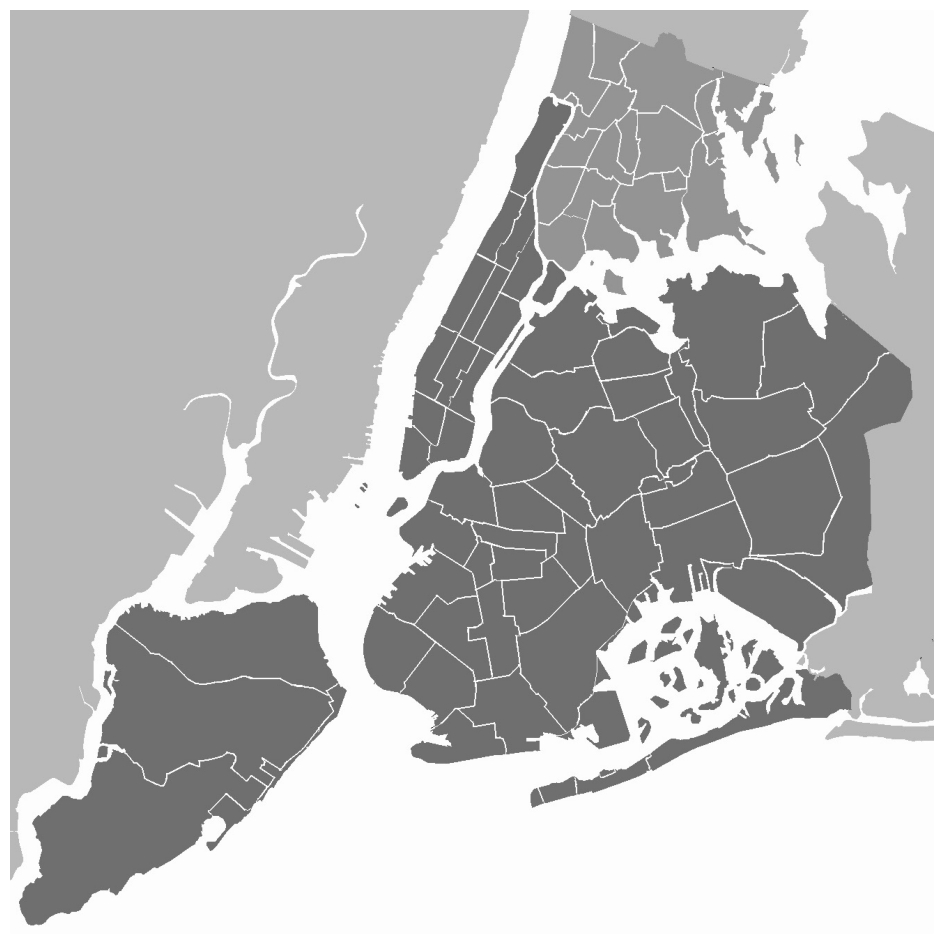

In [5]:
img = Image.open('archive/New_York_City_.png')

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(img, extent=(0, 1, 0, 1))
plt.show()

We can use the latitude and longitude values to plot points on the map.

In [7]:
coords = df.loc[:, ['longitude', 'latitude']]
coords

,longitude,latitude
0,-73.97237,40.64749
1,-73.98377,40.75362
2,-73.94190,40.80902
3,-73.95976,40.68514
4,-73.94399,40.79851
...,...,...
48890,-73.94995,40.67853
48891,-73.93317,40.70184
48892,-73.94867,40.81475
48893,-73.99112,40.75751


Let's apply a MinMaxScaler transform to these two columns so we can plot them along the axes.

In [8]:
min_max_scaler = MinMaxScaler()

coords = pd.DataFrame(min_max_scaler.fit_transform(coords), columns=coords.columns)

coords

,longitude,latitude
0,0.511921,0.357393
1,0.490469,0.614199
2,0.569257,0.748252
3,0.535649,0.448496
4,0.565324,0.722820
...,...,...
48890,0.554109,0.432502
48891,0.585684,0.488906
48892,0.556517,0.762117
48893,0.476639,0.623612


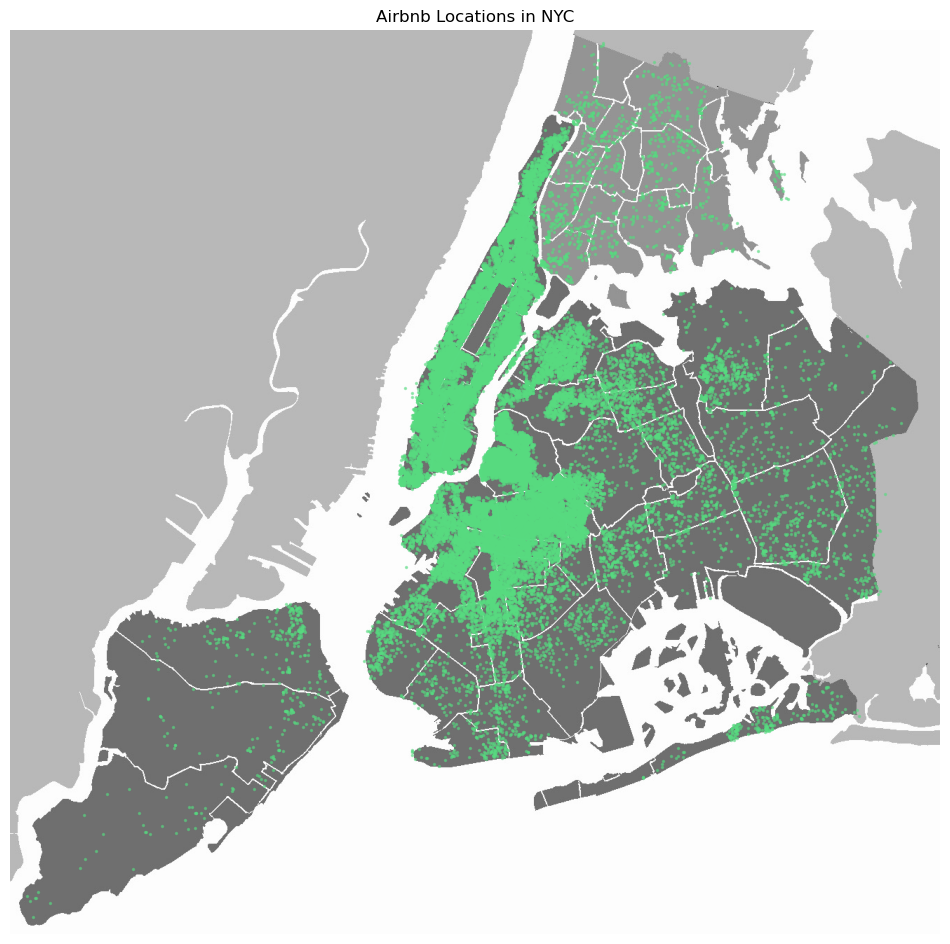

In [10]:
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(img, extent=(-0.02, 1.045, -0.02, 1.015))
plt.scatter(x=coords['longitude'], y=coords['latitude'], s=2, c='#57db80', alpha=0.5)
plt.title('Airbnb Locations in NYC')
plt.show()

### Cleaning

Let's start by removing unnecessary columns and dealing with missing values.

In [11]:
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [12]:
unneeded_columns = ['id', 'name', 'host_id', 'host_name']

df = df.drop(unneeded_columns, axis=1)

In [13]:
df

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [14]:
df.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [15]:
print("Total Missing values: ", df.isna().sum().sum())

Total Missing values:  20104


In [16]:
df.isna().mean()

neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
last_review                       0.205583
reviews_per_month                 0.205583
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

In [18]:
len(df['last_review'].unique())

1765

Because the missing values in the *last_review* column are difficult to deal with, we will drop that column and fill the NaN values in *reviews_per_month* with 0's (since a missing value implies there are no reviews for the location).

In [19]:
df = df.drop('last_review', axis=1)

df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [20]:
print("Total missing values: ", df.isna().sum().sum())

Total missing values:  0


#### Creating Labels

We want to be able to predict if a location will be available 365 days of the year. 

Let us change the *availability_365* column to be a simple binary column (where 1 denotes 365-availability and 0 denotes otherwise).

In [21]:
df

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,0.00,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,0.00,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,0.00,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,0.00,6,2


In [22]:
df['availability_365'] = df['availability_365'].apply(lambda x: 1 if x == 365 else 0)

In [24]:
df['availability_365'].value_counts() / len(df['availability_365'])

availability_365
0    0.973515
1    0.026485
Name: count, dtype: float64

We can see from the class distribution that we are dealing with severely skewed classes (365-availability only occurs in 2.65% of the data).

#### Encoding Features

Let's get a list of the unique values for each categorical feature, so we can decide on how to encode them.

In [25]:
df

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,1
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,0
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,1
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,0
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,0.00,2,0
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,0.00,2,0
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,0.00,1,0
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,0.00,6,0


In [26]:
{feature: df[feature].unique() for feature in df.columns if df.dtypes[feature] == 'object'}

{'neighbourhood_group': array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
       dtype=object),
 'neighbourhood': array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
        'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
        'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
        'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
        'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
        'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
        'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
        'SoHo', 'Upper East Side', 'Prospect Heights',
        'Washington Heights', 'Woodside', 'Brooklyn Heights',
        'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
        'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
        'Highbridge', 'Financial District', 'Ridgewood',
        'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
        'Ditm

It appears that all three categorical features are nominal (no ordering), so we will perform one-hot encoding on them.

In [27]:
def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix, dtype=int)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [29]:
df = onehot_encode(
    df,
    columns = ['neighbourhood_group', 'neighbourhood', 'room_type'],
    prefixes = ['G', 'N', 'R']
)

In [30]:
df

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,G_Bronx,G_Brooklyn,...,N_Williamsburg,N_Willowbrook,N_Windsor Terrace,N_Woodhaven,N_Woodlawn,N_Woodrow,N_Woodside,R_Entire home/apt,R_Private room,R_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,225,1,45,0.38,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,150,3,0,0.00,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,89,1,270,4.64,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,80,10,9,0.10,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,70,2,0,0.00,2,0,0,1,...,0,0,0,0,0,0,0,0,1,0
48891,40.70184,-73.93317,40,4,0,0.00,2,0,0,1,...,0,0,0,0,0,0,0,0,1,0
48892,40.81475,-73.94867,115,10,0,0.00,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48893,40.75751,-73.99112,55,1,0,0.00,6,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Splitting/Scaling

Our data is now in fully-numeric form, so let's scale the data so that each column has mean 0 and unit variance.

First, we need to split the data into X (features) and y (target).

In [31]:
y = df['availability_365'].copy()
X = df.drop('availability_365', axis=1).copy()

In [32]:
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,G_Bronx,G_Brooklyn,G_Manhattan,...,N_Williamsburg,N_Willowbrook,N_Windsor Terrace,N_Woodhaven,N_Woodlawn,N_Woodrow,N_Woodside,R_Entire home/apt,R_Private room,R_Shared room
0,-1.493849,-0.437652,-0.015493,-0.293996,-0.320414,-0.551511,-0.034716,-0.151071,1.196705,-0.891833,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,-1.040134,1.090893,-0.155887
1,0.452436,-0.684639,0.300974,-0.293996,0.487665,-0.445079,-0.156104,-0.151071,-0.835628,1.121286,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,0.961415,-0.916680,-0.155887
2,1.468399,0.222497,-0.011329,-0.196484,-0.522433,-0.682986,-0.186451,-0.151071,-0.835628,1.121286,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,-1.040134,1.090893,-0.155887
3,-0.803398,-0.164450,-0.265335,-0.293996,5.538156,2.221978,-0.186451,-0.151071,1.196705,-0.891833,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,0.961415,-0.916680,-0.155887
4,1.275660,0.177216,-0.302811,0.144807,-0.320414,-0.620379,-0.186451,-0.151071,-0.835628,1.121286,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,0.961415,-0.916680,-0.155887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,-0.924616,0.048089,-0.344452,-0.245240,-0.522433,-0.682986,-0.156104,-0.151071,1.196705,-0.891833,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,-1.040134,1.090893,-0.155887
48891,-0.497141,0.411637,-0.469373,-0.147729,-0.522433,-0.682986,-0.156104,-0.151071,1.196705,-0.891833,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,-1.040134,1.090893,-0.155887
48892,1.573480,0.075821,-0.157070,0.144807,-0.522433,-0.682986,-0.186451,-0.151071,-0.835628,1.121286,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,0.961415,-0.916680,-0.155887
48893,0.523774,-0.843881,-0.406912,-0.293996,-0.522433,-0.682986,-0.034716,-0.151071,-0.835628,1.121286,...,-0.295228,-0.004522,-0.056757,-0.042462,-0.015001,-0.004522,-0.069494,-1.040134,-0.916680,6.414894


Now that the data has been scaled, and we only need to split it into train and test sets.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=200)

### Modeling

Since we are dealing with tabular data, we will use a simple 2-hidden layer neural network.

In [34]:
X.shape

(48895, 236)

In [36]:
inputs = tf.keras.Input(shape=(X.shape[1], ), name='input_layer')

hidden_1 = tf.keras.layers.Dense(64, activation='relu', name='hidden_1')(inputs)
hidden_2 = tf.keras.layers.Dense(64, activation='relu', name='hidden_2')(hidden_1)

outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(hidden_2)

model = tf.keras.Model(inputs, outputs)

Let's generate a summary and graphical representation of the model for better understanding.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 236)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_1 (Dense)                     │ (None, 64)                  │          15,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_2 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,393 (75.75 KB)

 Trainable params: 19,393 (75.75 KB)

 Non-trainable params: 0 (0.00 B)

None


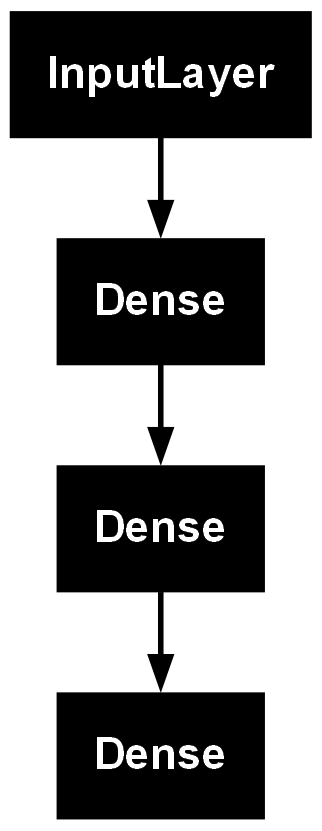

In [37]:
print(model.summary())
tf.keras.utils.plot_model(model)

### Training

Let us compute some class weights before fitting the model (since our classes are so skewed).

In [41]:
class_weight = dict(
    enumerate(
        class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = y_train.unique(),
            y = y_train
            )
    )
)
class_weight

{0: np.float64(0.512902742394725), 1: np.float64(19.875725900116144)}

In [47]:
batch_size = 32
epochs = 6

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history = model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    class_weight = class_weight,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/6
856/856 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7773 - auc: 0.8808 - loss: 0.4434 - val_accuracy: 0.6900 - val_auc: 0.7675 - val_loss: 0.6840 - learning_rate: 0.0010
Epoch 2/6
856/856 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7962 - auc: 0.9026 - loss: 0.3951 - val_accuracy: 0.7651 - val_auc: 0.7739 - val_loss: 0.5203 - learning_rate: 0.0010
Epoch 3/6
856/856 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8008 - auc: 0.9097 - loss: 0.3867 - val_accuracy: 0.8088 - val_auc: 0.7675 - val_loss: 0.4313 - learning_rate: 0.0010
Epoch 4/6
856/856 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8061 - auc: 0.9136 - loss: 0.3677 - val_accuracy: 0.7518 - val_auc: 0.7622 - val_loss: 0.5255 - learning_rate: 0.0010
Epoch 5/6
856/856 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8030 - auc: 0.9147 - loss: 0.3654 - val_accuracy: 0.7672 - val_auc: 0.7694 - val_loss: 0.5416 - learning_rate: 0.0010
Epoch 6/6
856/856 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8026 - auc: 0.9148 -

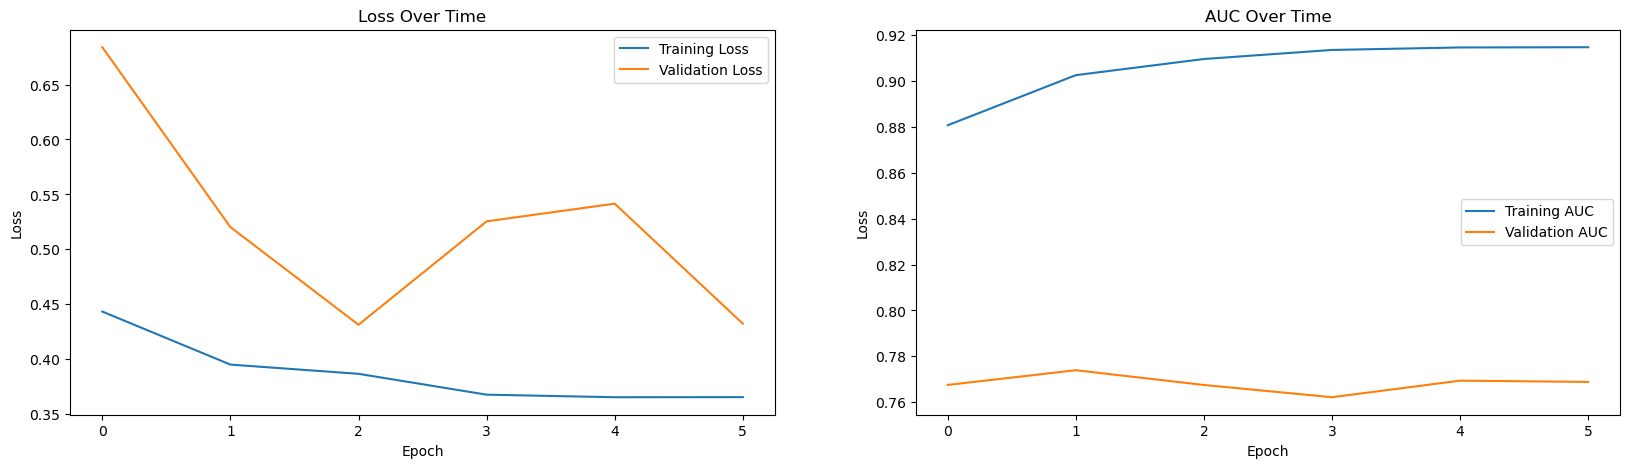

In [48]:
plt.figure(figsize=(20, 5))

epochs_range = range(epochs)
train_loss, val_loss = history.history['loss'], history.history['val_loss']
train_auc, val_auc = history.history['auc'], history.history['val_auc']

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('AUC Over Time')

plt.show()

### Results

In [49]:
results = model.evaluate(X_test, y_test, verbose=0)

print("Accuracy: ", results[1])
print("ROC AUC: ", results[2])

Accuracy:  0.8159383535385132
ROC AUC:  0.7757582664489746


In [46]:
# np.argmax(val_auc)

np.int64(6)

In [59]:
(y_test == y_pred).mean()

np.float64(0.815938373440589)

In [64]:
y_pred = pd.Series((np.squeeze(model.predict(X_test)) > 0.5).astype(int))
y_pred

459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


0        0
1        0
2        0
3        0
4        1
        ..
14664    1
14665    0
14666    1
14667    0
14668    1
Length: 14669, dtype: int64

In [67]:
y_true = y_test.reset_index(drop=True)
y_true

0        0
1        0
2        0
3        0
4        0
        ..
14664    0
14665    0
14666    0
14667    0
14668    0
Name: availability_365, Length: 14669, dtype: int64

In [72]:
positive_indices = y_true[y_true == 1].index
positive_indices

Index([   16,    31,    40,    71,    97,   104,   148,   258,   280,   304,
       ...
       14201, 14252, 14276, 14299, 14349, 14405, 14418, 14481, 14503, 14564],
      dtype='int64', length=434)

In [75]:
(y_true[positive_indices] == y_pred[positive_indices]).mean()

np.float64(0.631336405529954)